
# Klasifikasi Tingkat Stres Berdasarkan Pola Tidur
# Menggunakan Logistic Regression, K-NN, Naive Bayes, dan Decision Tree

## 1. Pemahaman Dataset

### 1.1 Sumber Data dan Variabel

Dataset SaYoPillow merupakan dataset yang berisi data tentang hubungan antara pola tidur dan tingkat stres. Dataset ini berasal dari penelitian tentang Smart-Yoga Pillow (SaYoPillow), sebuah perangkat edge yang diusulkan untuk membantu memahami hubungan antara stres dan tidur.

**Sumber Dataset**: Dataset ini dirilis sebagai bagian dari penelitian yang dipublikasikan dalam IEEE Transactions on Consumer Electronics (TCE) pada tahun 2021 dan tersedia di Kaggle.

**Referensi**:
1. L. Rachakonda, A. K. Bapatla, S. P. Mohanty, and E. Kougianos, "SaYoPillow: Blockchain-Integrated Privacy-Assured IoMT Framework for Stress Management Considering Sleeping Habits", IEEE Transactions on Consumer Electronics (TCE), Vol. 67, No. 1, Feb 2021, pp. 20-29.
2. L. Rachakonda, S. P. Mohanty, E. Kougianos, K. Karunakaran, and M. Ganapathiraju, "Smart-Pillow: An IoT based Device for Stress Detection Considering Sleeping Habits", in Proceedings of the 4th IEEE International Symposium on Smart Electronic Systems (iSES), 2018, pp. 161--166.

**Variabel dalam Dataset**:
1. `snoring_rate`: Tingkat mendengkur pengguna
2. `respiration_rate`: Tingkat pernapasan
3. `body_temperature`: Suhu tubuh
4. `limb_movement`: Tingkat pergerakan anggota tubuh
5. `blood_oxygen`: Kadar oksigen dalam darah
6. `eye_movement`: Gerakan mata
7. `sleeping_hours`: Jumlah jam tidur
8. `heart_rate`: Detak jantung
9. `stress_level`: Tingkat stres (Target, 0-4)
   - 0: Rendah/Normal
   - 1: Medium Rendah
   - 2: Medium
   - 3: Medium Tinggi
   - 4: Tinggi

### 1.2 Import Library yang Dibutuhkan

In [1]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.tree import plot_tree
import warnings

# Mengabaikan warning
warnings.filterwarnings('ignore')

# Mengatur visualisasi
plt.style.use('ggplot')
sns.set(style="whitegrid")

### 1.3 Memuat dan Melihat Data


In [6]:
# Membaca dataset
df = pd.read_csv('SaYoPillow.csv')

# Memeriksa 5 data pertama
print("5 Data Pertama:")
df.head()

# Memeriksa ukuran dataset
print("\nUkuran Dataset:")
print(f"Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")

# Memeriksa informasi dataset
print("\nInformasi Dataset:")
df.info()

# Memeriksa statistik deskriptif
print("\nStatistik Deskriptif:")
df.describe()

# Memeriksa nilai unik untuk stress_level (target)
print("\nDistribusi Nilai Target (sl):")
print(df['sl'].value_counts())
print("\nPersentase:")
print(df['sl'].value_counts(normalize=True) * 100)

5 Data Pertama:

Ukuran Dataset:
Jumlah Baris: 630, Jumlah Kolom: 9

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sr      630 non-null    float64
 1   rr      630 non-null    float64
 2   t       630 non-null    float64
 3   lm      630 non-null    float64
 4   bo      630 non-null    float64
 5   rem     630 non-null    float64
 6   sr.1    630 non-null    float64
 7   hr      630 non-null    float64
 8   sl      630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB

Statistik Deskriptif:

Distribusi Nilai Target (sl):
sl
3    126
1    126
0    126
2    126
4    126
Name: count, dtype: int64

Persentase:
sl
3    20.0
1    20.0
0    20.0
2    20.0
4    20.0
Name: proportion, dtype: float64


### 1.4 Visualisasi Awal Data


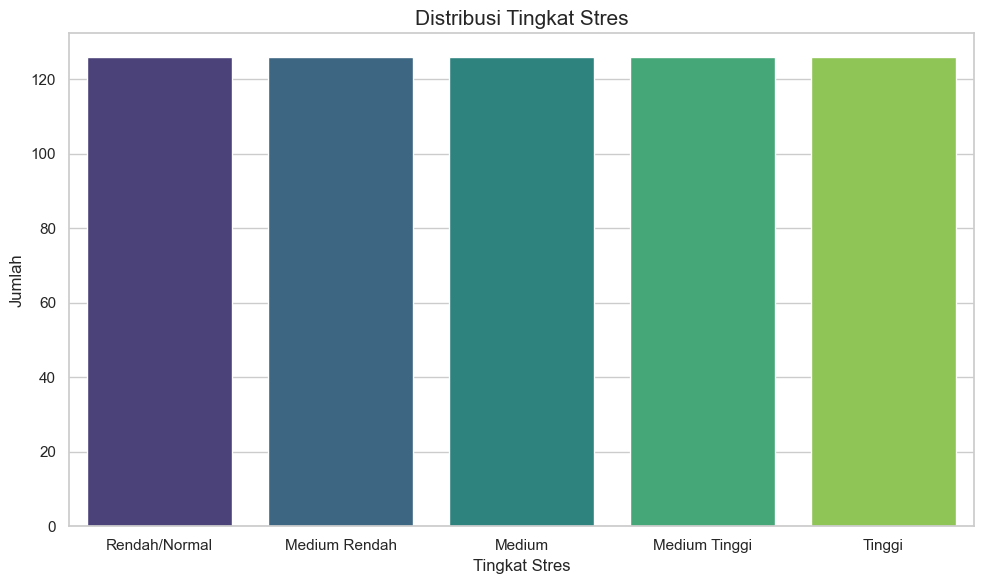

In [8]:
# Visualisasi distribusi target
plt.figure(figsize=(10, 6))
sns.countplot(x='sl', data=df, palette='viridis')
plt.title('Distribusi Tingkat Stres', fontsize=15)
plt.xlabel('Tingkat Stres', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks([0, 1, 2, 3, 4], ['Rendah/Normal', 'Medium Rendah', 'Medium', 'Medium Tinggi', 'Tinggi'])
plt.tight_layout()
plt.show()

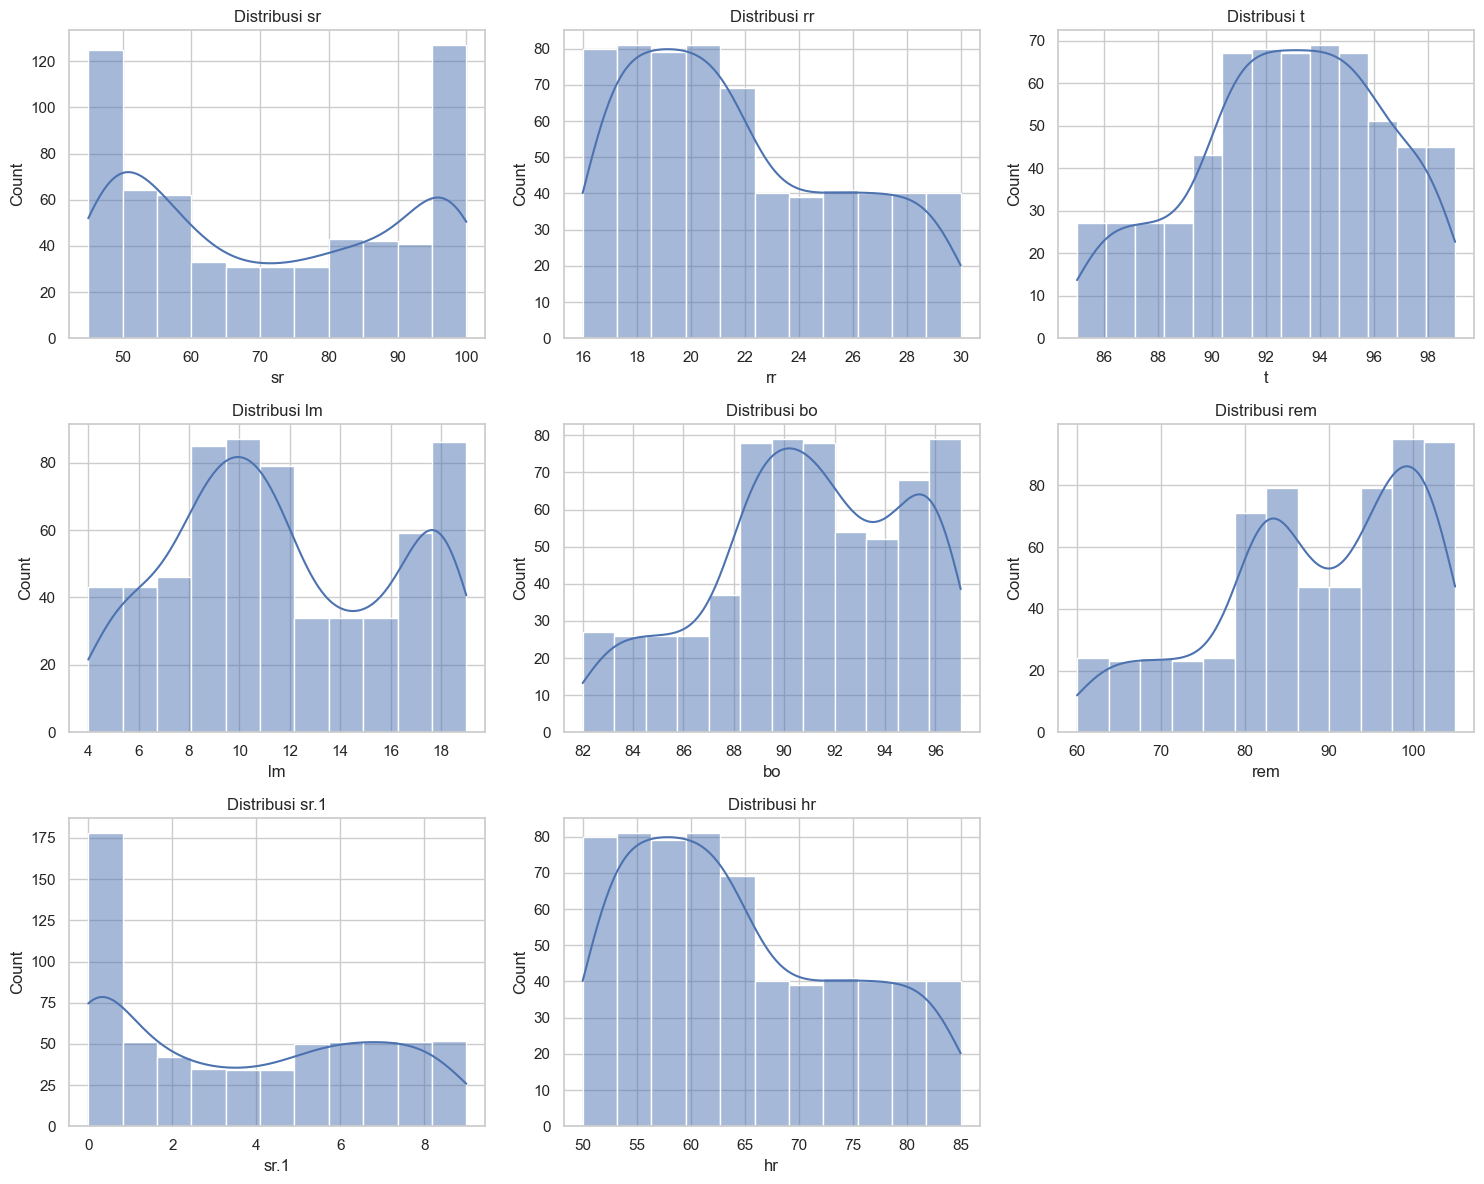

In [9]:
# Visualisasi distribusi setiap fitur
plt.figure(figsize=(15, 12))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}', fontsize=12)
plt.tight_layout()
plt.show()

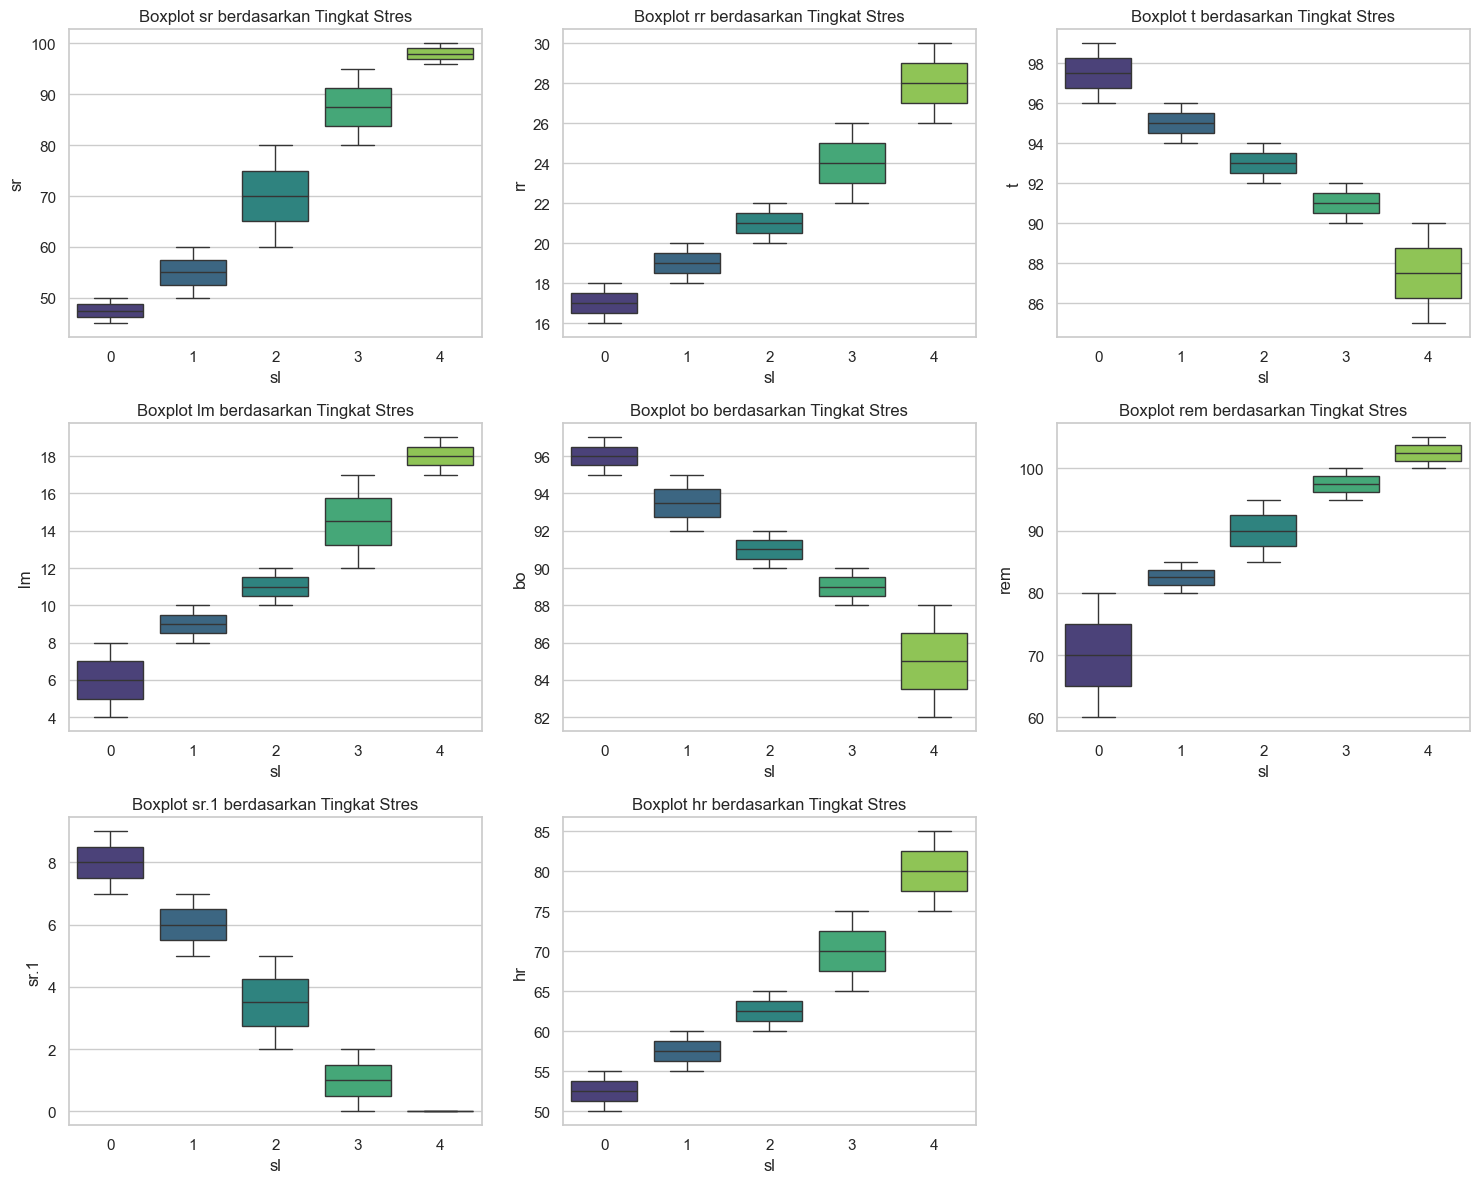

In [12]:
# Visualisasi boxplot untuk melihat outlier
plt.figure(figsize=(15, 12))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='sl', y=col, data=df, palette='viridis')
    plt.title(f'Boxplot {col} berdasarkan Tingkat Stres', fontsize=12)
plt.tight_layout()
plt.show()

## 2. Eksplorasi Data dan Preprocessing

### 2.1 Memeriksa Missing Values



In [14]:
# Memeriksa missing values
print("Jumlah Missing Values per Kolom:")
print(df.isnull().sum())


Jumlah Missing Values per Kolom:
sr      0
rr      0
t       0
lm      0
bo      0
rem     0
sr.1    0
hr      0
sl      0
dtype: int64


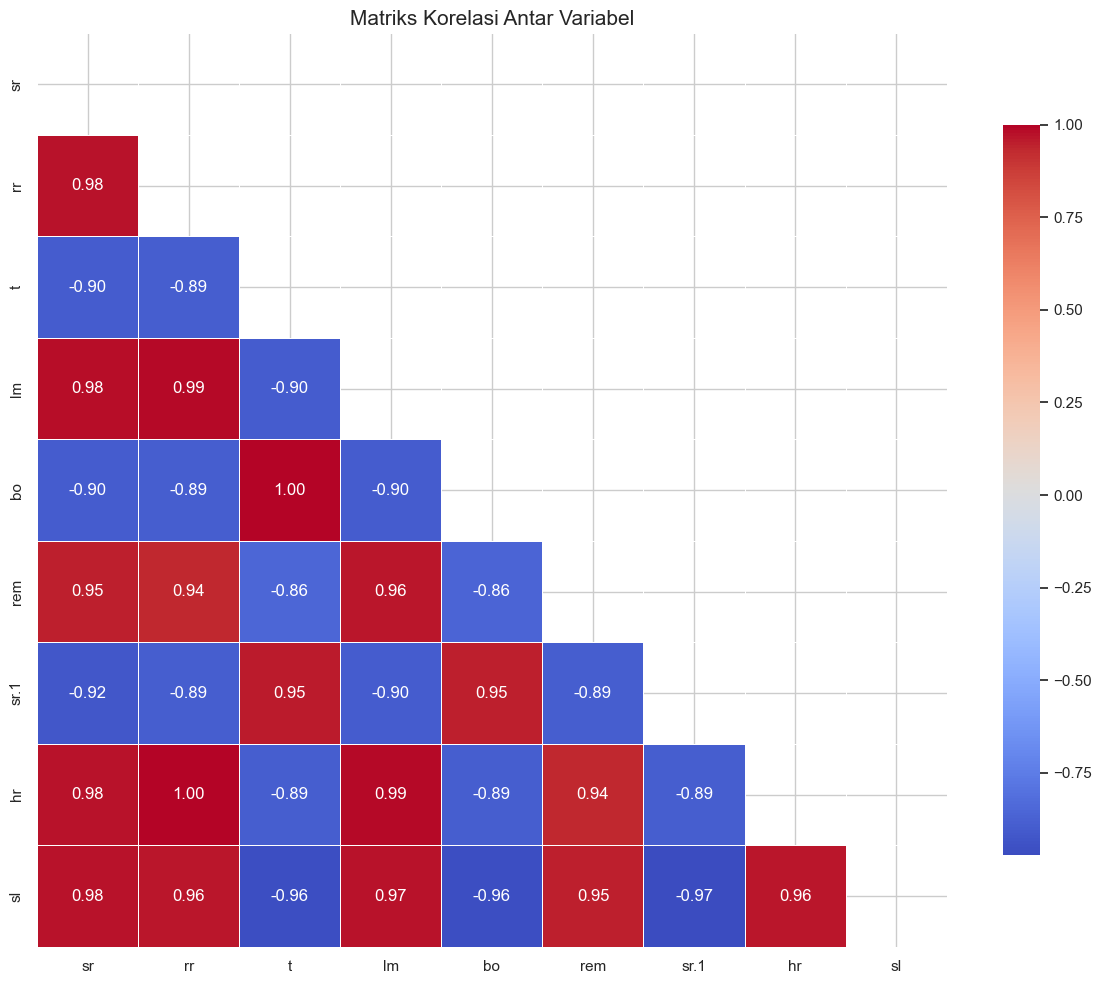

In [15]:
# Menghitung dan visualisasi korelasi antar variabel
plt.figure(figsize=(12, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriks Korelasi Antar Variabel', fontsize=15)
plt.tight_layout()
plt.show()


Korelasi Setiap Fitur dengan Tingkat Stres:
sr      0.975322
lm      0.971071
hr      0.963516
rr      0.963516
rem     0.951988
bo     -0.961092
t      -0.962354
sr.1   -0.973036
Name: sl, dtype: float64


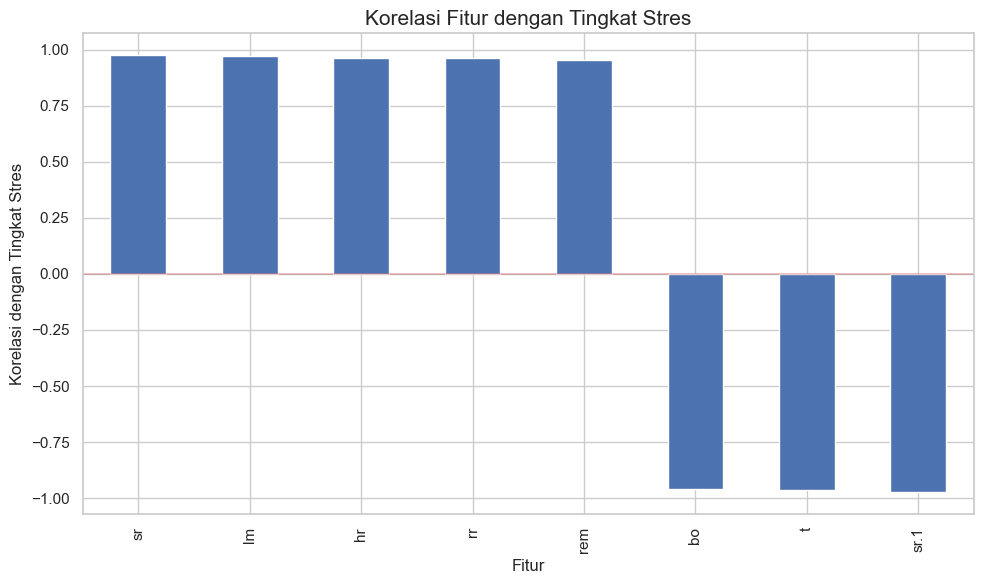

In [18]:
# Mengurutkan korelasi dengan variabel target (stress_level)
print("\nKorelasi Setiap Fitur dengan Tingkat Stres:")
target_corr = corr['sl'].drop('sl').sort_values(ascending=False)
print(target_corr)

# Visualisasi korelasi dengan target
plt.figure(figsize=(10, 6))
target_corr.plot(kind='bar')
plt.title('Korelasi Fitur dengan Tingkat Stres', fontsize=15)
plt.xlabel('Fitur', fontsize=12)
plt.ylabel('Korelasi dengan Tingkat Stres', fontsize=12)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 Normalisasi/Standarisasi Data


In [21]:
# Membagi data menjadi fitur (X) dan target (y)
X = df.drop('sl', axis=1)
y = df['sl']

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Melihat hasil standarisasi
print("Data setelah standarisasi:")
X_scaled_df.head()

Data setelah standarisasi:


,sr,rr,t,lm,bo,rem,sr.1,hr
0,1.146845,0.979066,-0.272195,1.140539,-0.271838,0.934005,-0.609407,0.979066
1,1.035260,0.833720,-0.353853,0.972949,-0.345696,0.873421,-0.703767,0.833720
2,-0.599252,-0.454206,0.907316,-0.395697,1.051448,-0.294506,1.081206,-0.454206
3,0.731501,0.438056,-0.576145,0.516734,-0.546753,0.708498,-0.960635,0.438056
4,-1.212970,-1.148636,1.438095,-1.211299,1.371498,-1.347997,1.490099,-1.148636


### 2.4 Pembagian Data untuk Training dan Testing


In [22]:
# Membagi data menjadi set training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Memeriksa distribusi kelas pada data training dan testing
print("Distribusi Target pada Training Set:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nDistribusi Target pada Testing Set:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

Distribusi Target pada Training Set:
sl
0    20.039683
4    20.039683
1    20.039683
2    20.039683
3    19.841270
Name: proportion, dtype: float64

Distribusi Target pada Testing Set:
sl
3    20.634921
0    19.841270
1    19.841270
4    19.841270
2    19.841270
Name: proportion, dtype: float64


## 3. Implementasi Model

### 3.1 Logistic Regression



Logistic Regression Accuracy: 1.0000
Logistic Regression Log Loss: 0.0628


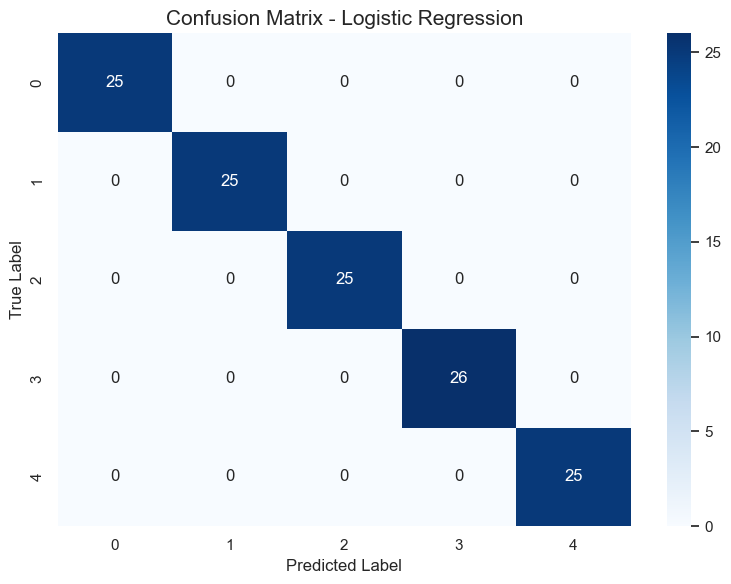


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [23]:
# Membuat model Logistic Regression
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

# Melatih model
lr_model.fit(X_train, y_train)

# Prediksi pada data testing
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)

# Mengukur performa
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_loss = log_loss(y_test, lr_prob)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression Log Loss: {lr_loss:.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Logistic Regression:")
print(classification_report(y_test, lr_pred))

### 3.2 K-Nearest Neighbors (KNN)


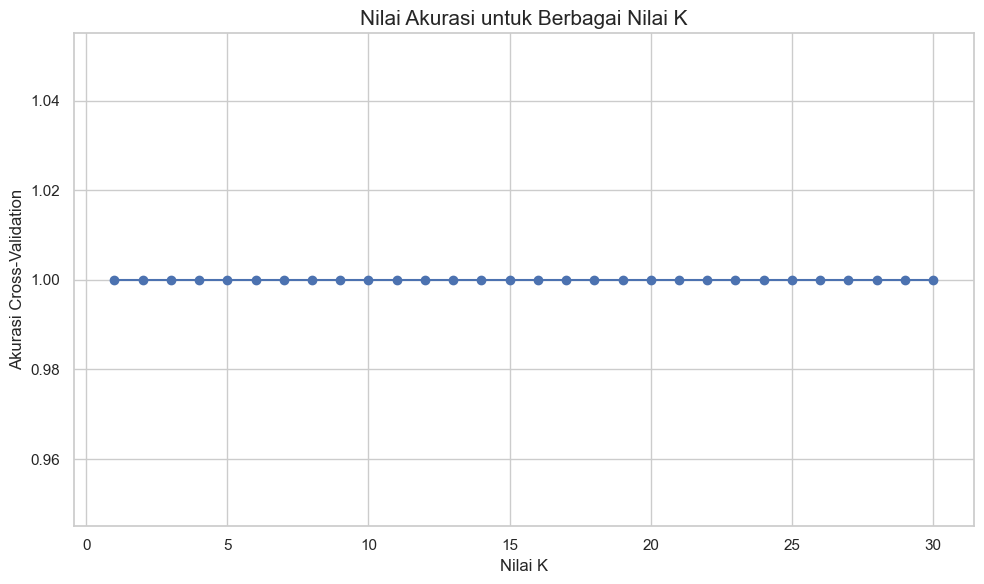

Nilai K optimal: 1
KNN Accuracy: 1.0000
KNN Log Loss: 0.0000


In [24]:
# Menentukan nilai optimal untuk k
k_values = range(1, 31)
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Visualisasi hasil pencarian nilai k optimal
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o')
plt.title('Nilai Akurasi untuk Berbagai Nilai K', fontsize=15)
plt.xlabel('Nilai K', fontsize=12)
plt.ylabel('Akurasi Cross-Validation', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Menentukan nilai k optimal
optimal_k = k_values[k_scores.index(max(k_scores))]
print(f"Nilai K optimal: {optimal_k}")

# Membuat model KNN dengan nilai k optimal
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

# Melatih model
knn_model.fit(X_train, y_train)

# Prediksi pada data testing
knn_pred = knn_model.predict(X_test)
knn_prob = knn_model.predict_proba(X_test)

# Mengukur performa
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_loss = log_loss(y_test, knn_prob)

print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"KNN Log Loss: {knn_loss:.4f}")

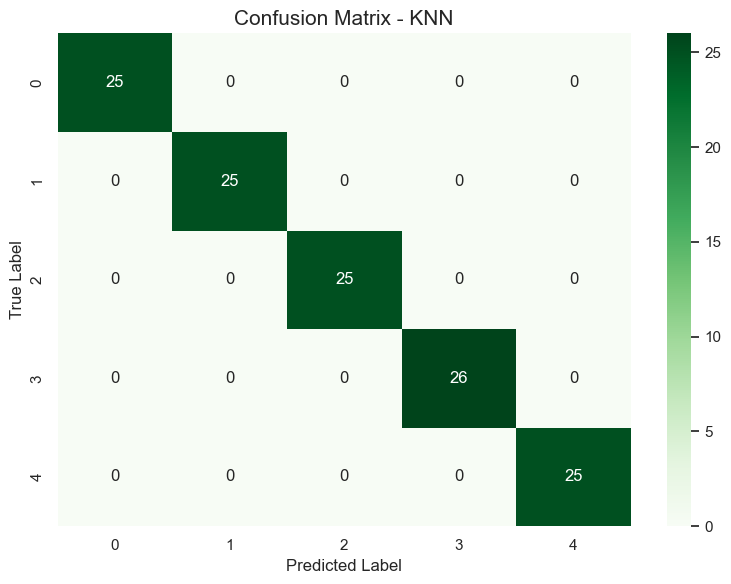


Classification Report - KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [25]:
# Confusion matrix
plt.figure(figsize=(8, 6))
knn_cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix - KNN', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - KNN:")
print(classification_report(y_test, knn_pred))

### 3.3 Naive Bayes


Naive Bayes Accuracy: 1.0000
Naive Bayes Log Loss: 0.0000


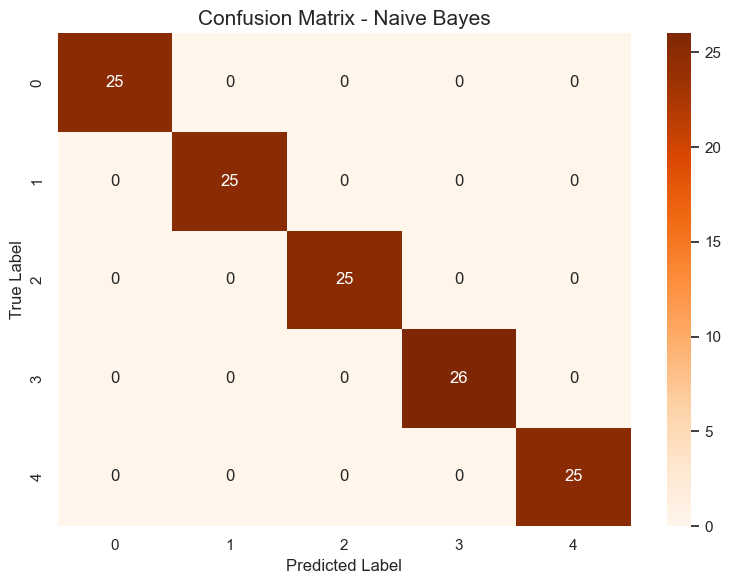


Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [26]:
# Membuat model Naive Bayes
nb_model = GaussianNB()

# Melatih model
nb_model.fit(X_train, y_train)

# Prediksi pada data testing
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)

# Mengukur performa
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_loss = log_loss(y_test, nb_prob)

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes Log Loss: {nb_loss:.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
nb_cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix - Naive Bayes', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Naive Bayes:")
print(classification_report(y_test, nb_pred))

### 3.4 Decision Tree


Decision Tree Accuracy: 0.9683
Decision Tree Log Loss: 1.1442


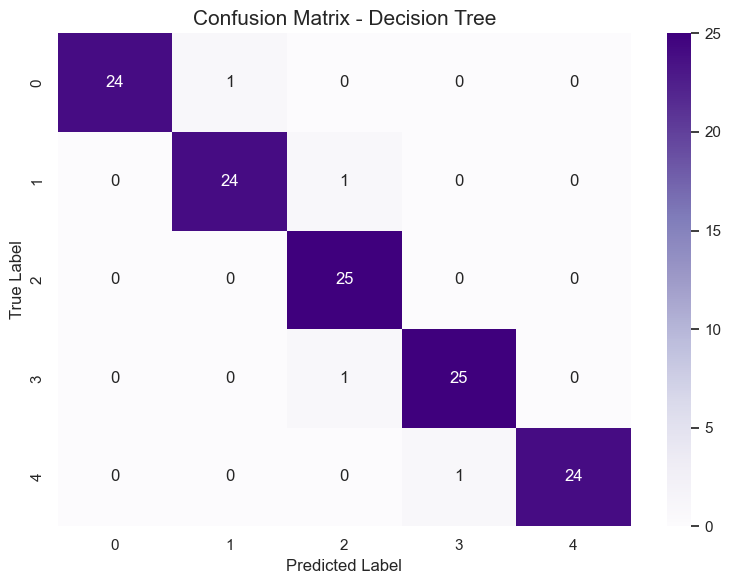


Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      0.96      0.96        25
           2       0.93      1.00      0.96        25
           3       0.96      0.96      0.96        26
           4       1.00      0.96      0.98        25

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126



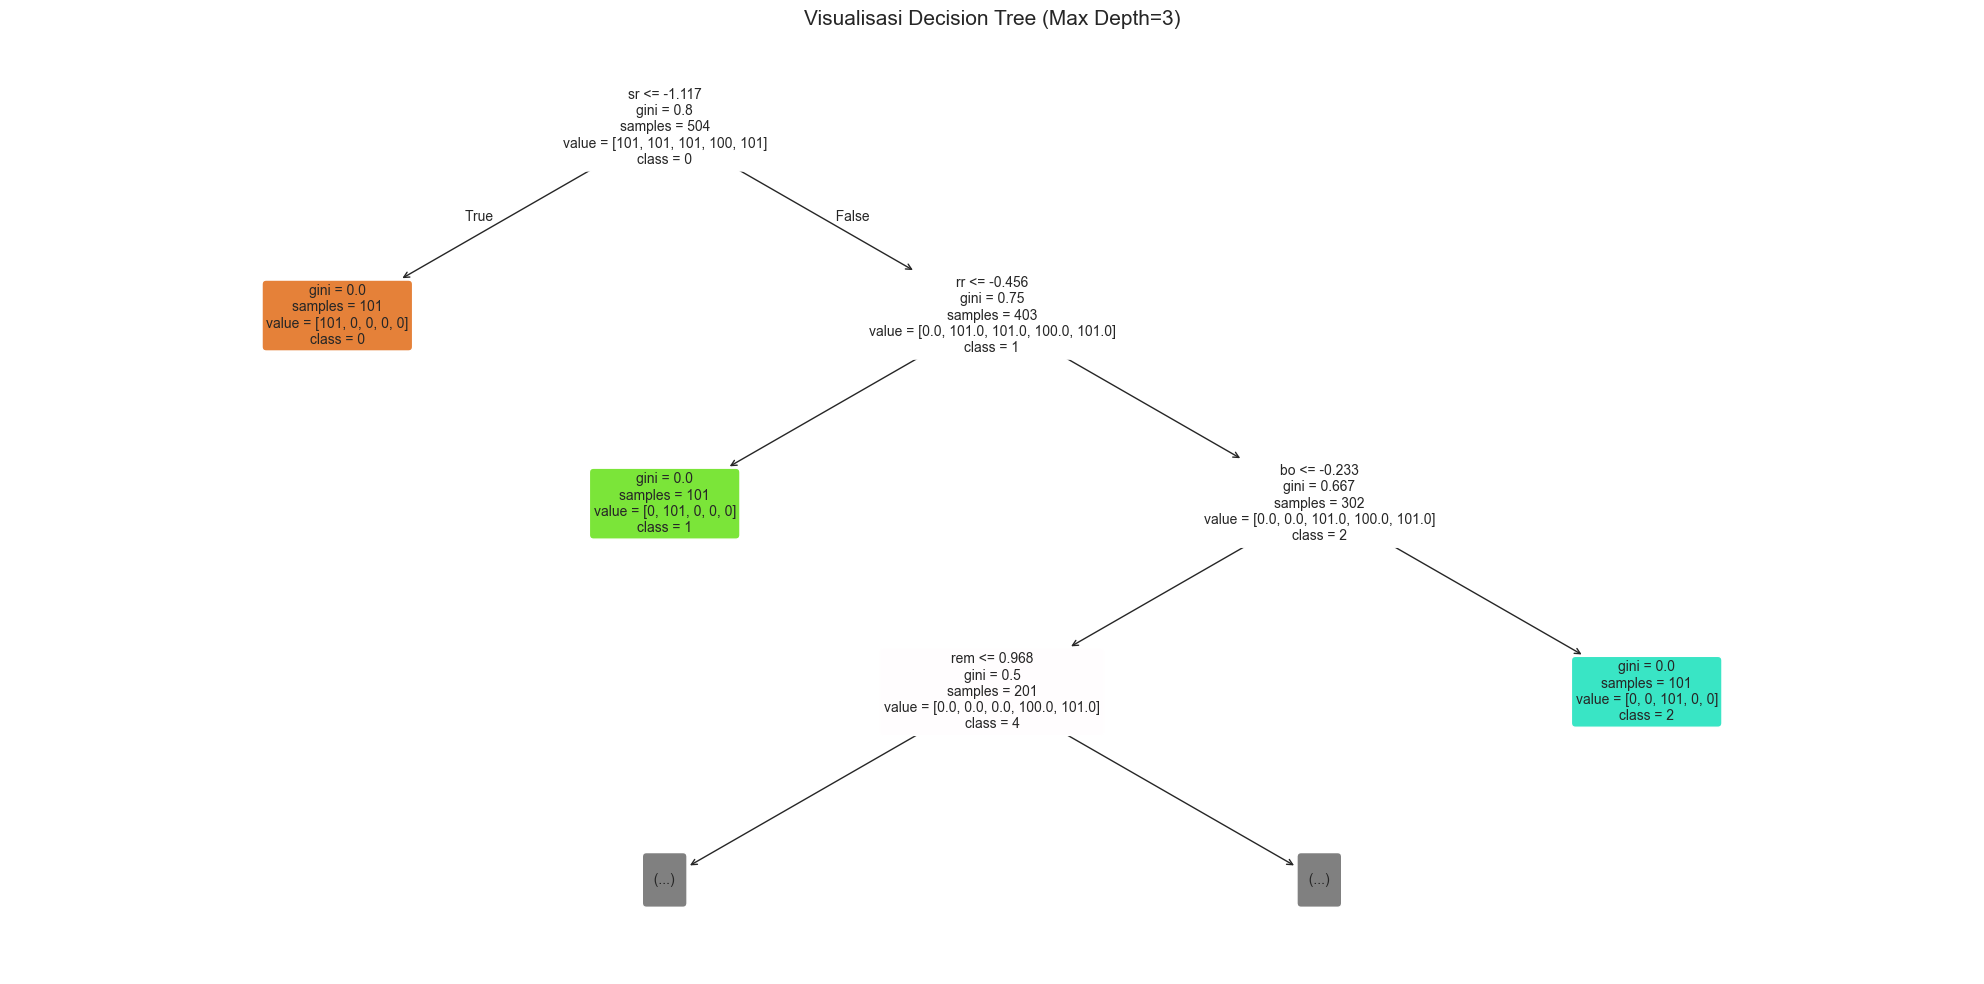

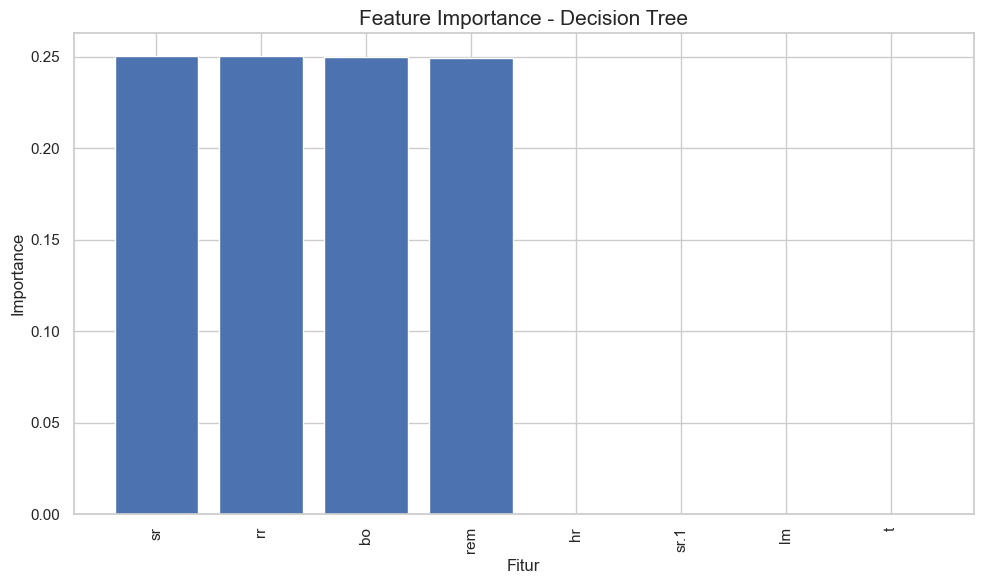

In [27]:
# Membuat model Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# Melatih model
dt_model.fit(X_train, y_train)

# Prediksi pada data testing
dt_pred = dt_model.predict(X_test)
dt_prob = dt_model.predict_proba(X_test)

# Mengukur performa
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_loss = log_loss(y_test, dt_prob)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Decision Tree Log Loss: {dt_loss:.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
dt_cm = confusion_matrix(y_test, dt_pred)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix - Decision Tree', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Decision Tree:")
print(classification_report(y_test, dt_pred))

# Visualisasi Decision Tree 
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=X.columns, class_names=['0', '1', '2', '3', '4'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Visualisasi Decision Tree (Max Depth=3)', fontsize=15)
plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(10, 6))
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title('Feature Importance - Decision Tree', fontsize=15)
plt.xlabel('Fitur', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Evaluasi Model

### 4.1 Perbandingan Akurasi Model


In [28]:
# Membuat dataframe untuk perbandingan akurasi
models = ['Logistic Regression', 'KNN', 'Naive Bayes', 'Decision Tree']
accuracies = [lr_accuracy, knn_accuracy, nb_accuracy, dt_accuracy]
losses = [lr_loss, knn_loss, nb_loss, dt_loss]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Log Loss': losses
})

print("Perbandingan Performa Model:")
comparison_df

Perbandingan Performa Model:


,Model,Accuracy,Log Loss
0,Logistic Regression,1.000000,6.280729e-02
1,KNN,1.000000,2.220446e-16
2,Naive Bayes,1.000000,2.396672e-16
3,Decision Tree,0.968254,1.144243e+00


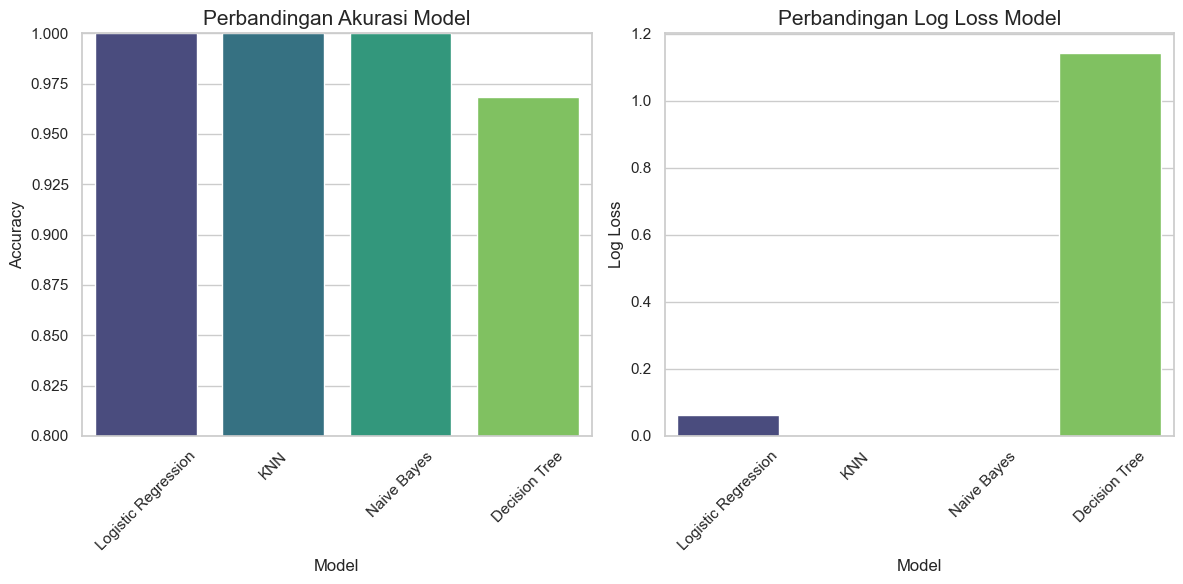

In [29]:
# Visualisasi perbandingan akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Perbandingan Akurasi Model', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.8, 1.0)  # Menyesuaikan dengan nilai akurasi
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Log Loss', data=comparison_df, palette='viridis')
plt.title('Perbandingan Log Loss Model', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 4.2 Perbandingan Confusion Matrix


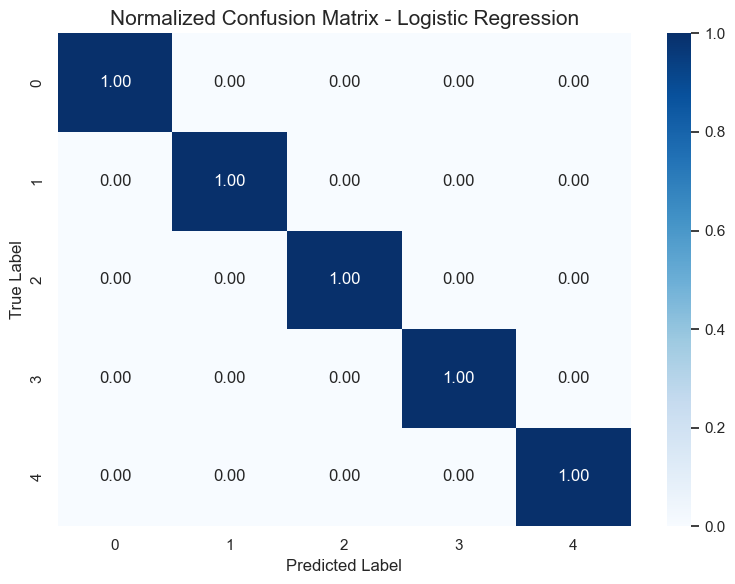

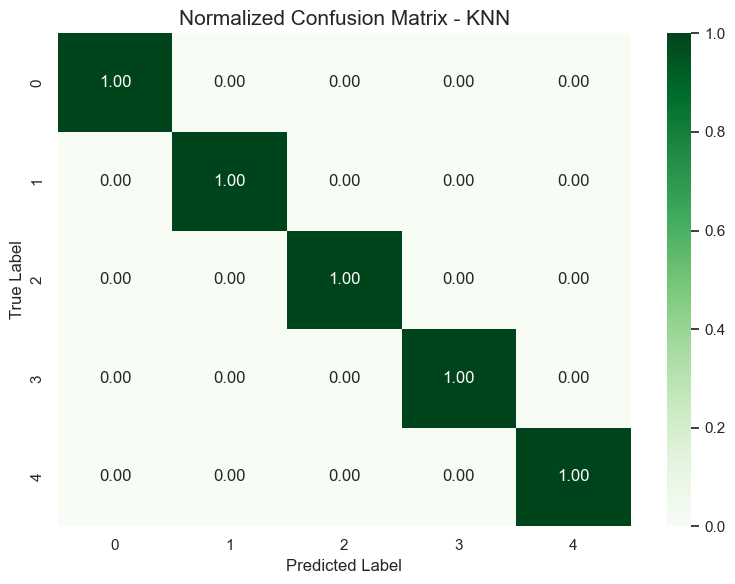

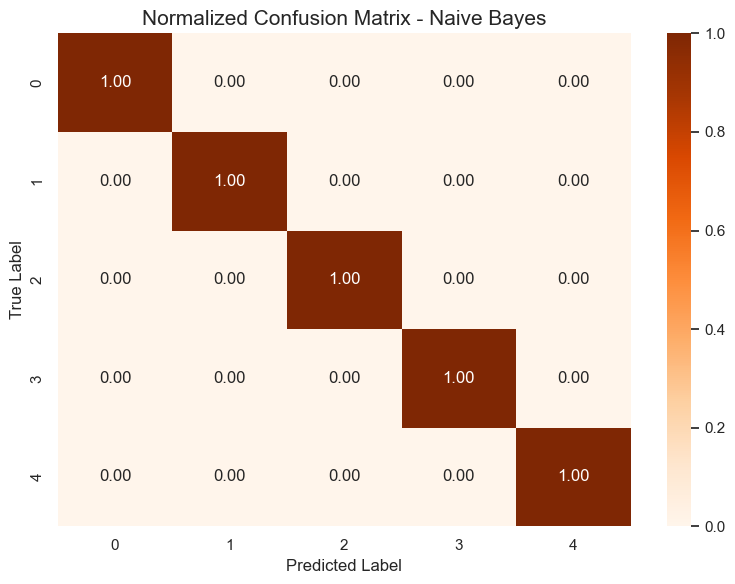

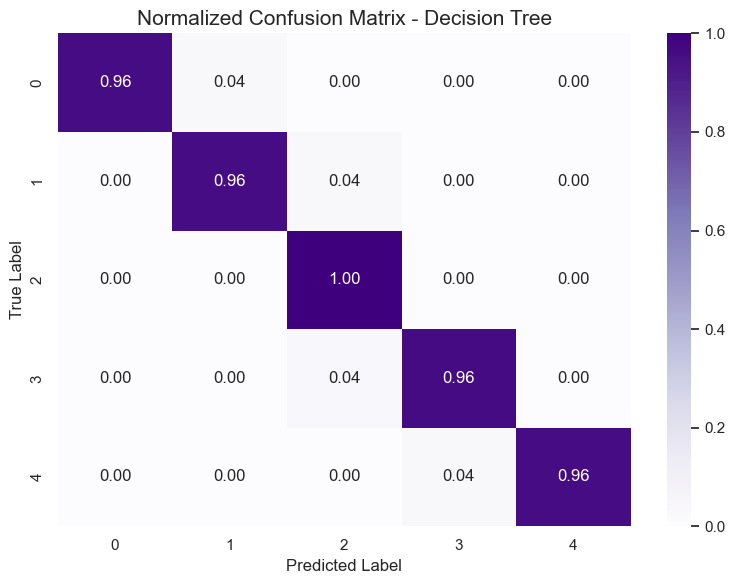

In [30]:
# Fungsi untuk menampilkan confusion matrix yang dinormalisasi
def plot_normalized_cm(cm, title, cmap='Blues'):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=cmap, 
                xticklabels=['0', '1', '2', '3', '4'],
                yticklabels=['0', '1', '2', '3', '4'])
    plt.title(title, fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Menampilkan confusion matrix yang dinormalisasi untuk setiap model
plot_normalized_cm(lr_cm, 'Normalized Confusion Matrix - Logistic Regression', 'Blues')
plot_normalized_cm(knn_cm, 'Normalized Confusion Matrix - KNN', 'Greens')
plot_normalized_cm(nb_cm, 'Normalized Confusion Matrix - Naive Bayes', 'Oranges')
plot_normalized_cm(dt_cm, 'Normalized Confusion Matrix - Decision Tree', 'Purples')

### 4.3 Validasi Silang (Cross-Validation)


Logistic Regression - Cross-Validation Accuracy: 1.0000 (±0.0000)
KNN - Cross-Validation Accuracy: 1.0000 (±0.0000)
Naive Bayes - Cross-Validation Accuracy: 1.0000 (±0.0000)
Decision Tree - Cross-Validation Accuracy: 0.9857 (±0.0093)


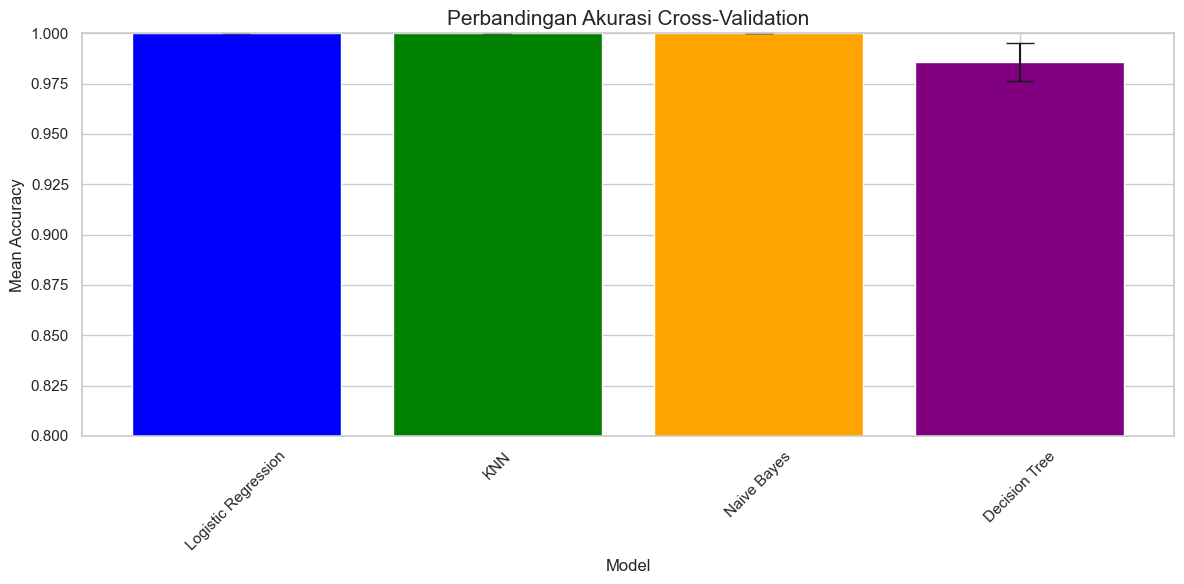

In [31]:
# Melakukan validasi silang untuk setiap model
cv_results = {}
models_cv = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=optimal_k),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Melakukan cross-validation untuk setiap model
for name, model in models_cv.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    print(f"{name} - Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Visualisasi hasil cross-validation
plt.figure(figsize=(12, 6))
cv_means = [cv_results[model].mean() for model in models]
cv_std = [cv_results[model].std() for model in models]

plt.bar(models, cv_means, yerr=cv_std, capsize=10, color=['blue', 'green', 'orange', 'purple'])
plt.title('Perbandingan Akurasi Cross-Validation', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.ylim(0.8, 1.0)  # Menyesuaikan dengan nilai akurasi
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Analisis Hasil

### 5.1 Grafik Fit untuk Beberapa Algoritma

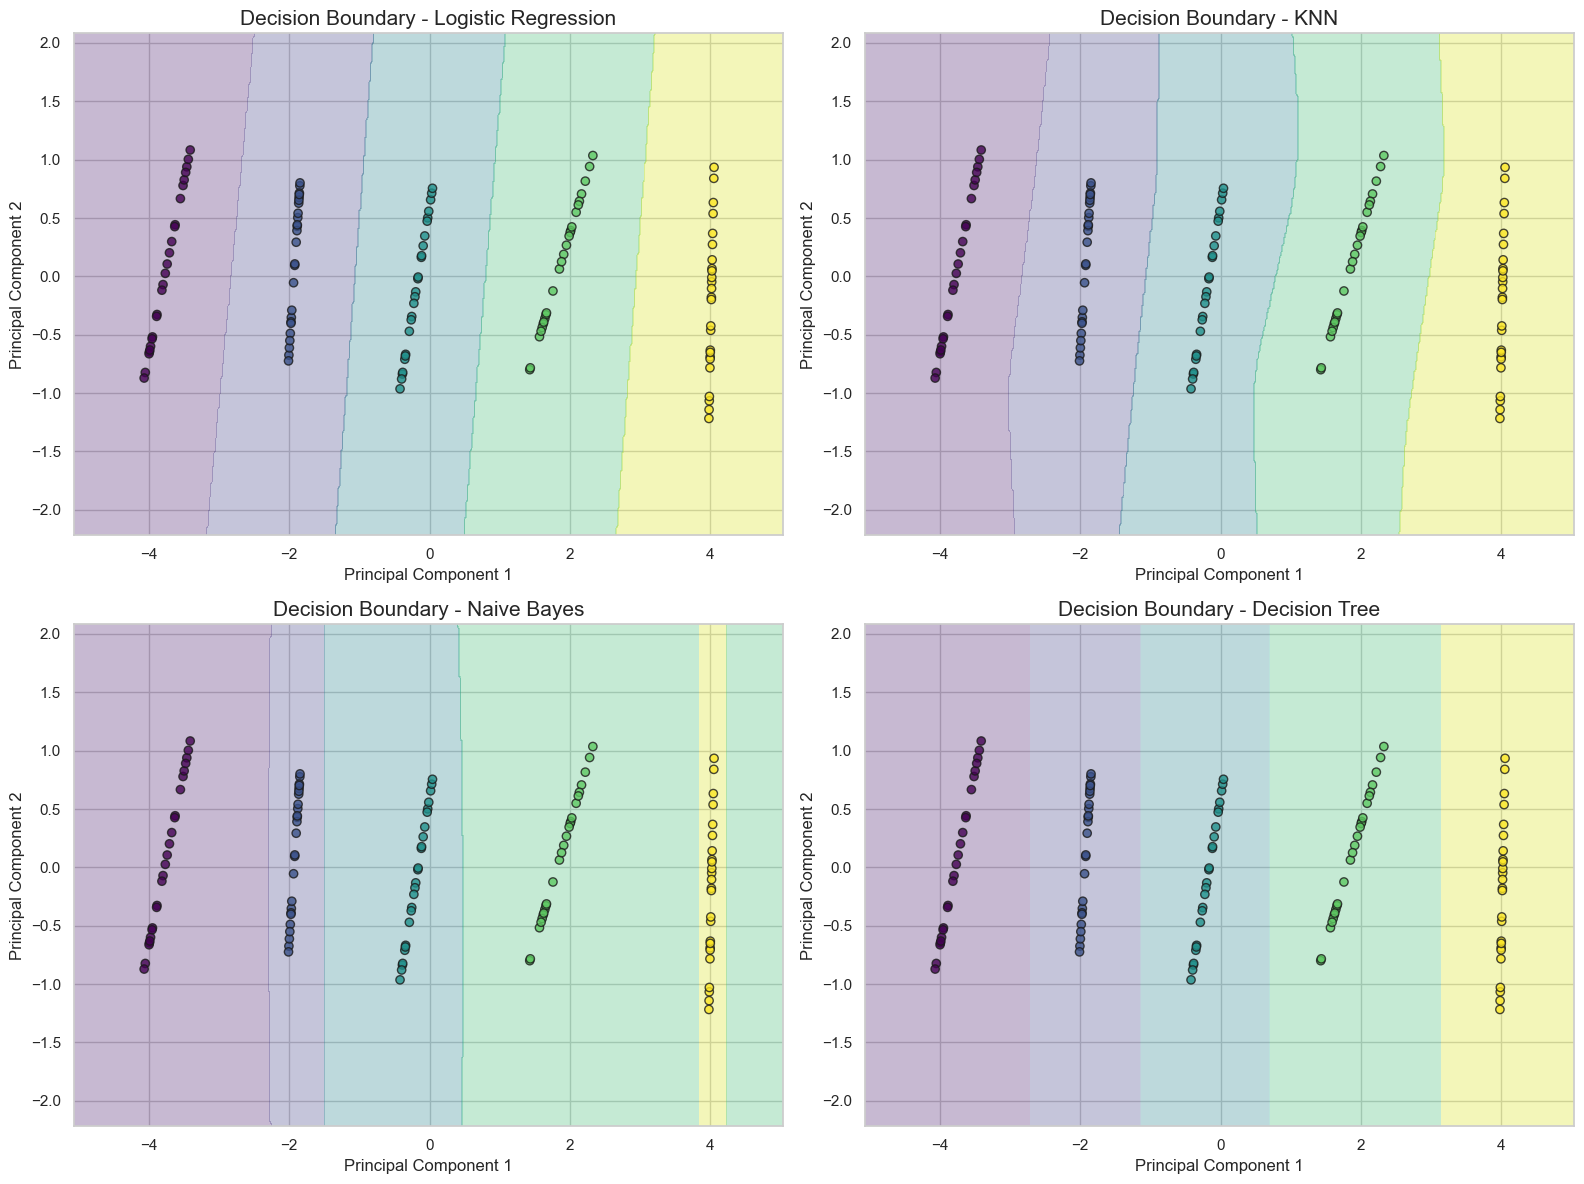

Variance explained by PCA components: [0.93714235 0.04074336]
Total variance explained: 0.9779


In [ ]:
# Mengambil sampel acak dari data testing untuk visualisasi (agar tidak terlalu ramai)
np.random.seed(42)
sample_indices = np.random.choice(range(len(X_test)), size=100, replace=False)
X_sample = X_test[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Untuk visualisasi, menggunakan PCA untuk mengurangi dimensi menjadi 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Membuat mesh grid untuk visualisasi decision boundary
def plot_decision_boundary(model, X, y, title, ax=None):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', 
                         cmap='viridis', alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)
    return ax

# Melatih model pada data PCA
lr_model_pca = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
lr_model_pca.fit(X_train_pca, y_train)

knn_model_pca = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model_pca.fit(X_train_pca, y_train)

nb_model_pca = GaussianNB()
nb_model_pca.fit(X_train_pca, y_train)

dt_model_pca = DecisionTreeClassifier(random_state=42)
dt_model_pca.fit(X_train_pca, y_train)

# Visualisasi decision boundary untuk semua model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_decision_boundary(lr_model_pca, X_test_pca, y_test, 'Decision Boundary - Logistic Regression', axes[0, 0])
plot_decision_boundary(knn_model_pca, X_test_pca, y_test, 'Decision Boundary - KNN', axes[0, 1])
plot_decision_boundary(nb_model_pca, X_test_pca, y_test, 'Decision Boundary - Naive Bayes', axes[1, 0])
plot_decision_boundary(dt_model_pca, X_test_pca, y_test, 'Decision Boundary - Decision Tree', axes[1, 1])

plt.tight_layout()
plt.show()

# Melihat penjelasan dari PCA components
pca_explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PCA components: {pca_explained_variance}")
print(f"Total variance explained: {sum(pca_explained_variance):.4f}")

### 5.2 Analisis Kekuatan dan Kelemahan Model


<Figure size 1200x800 with 0 Axes>

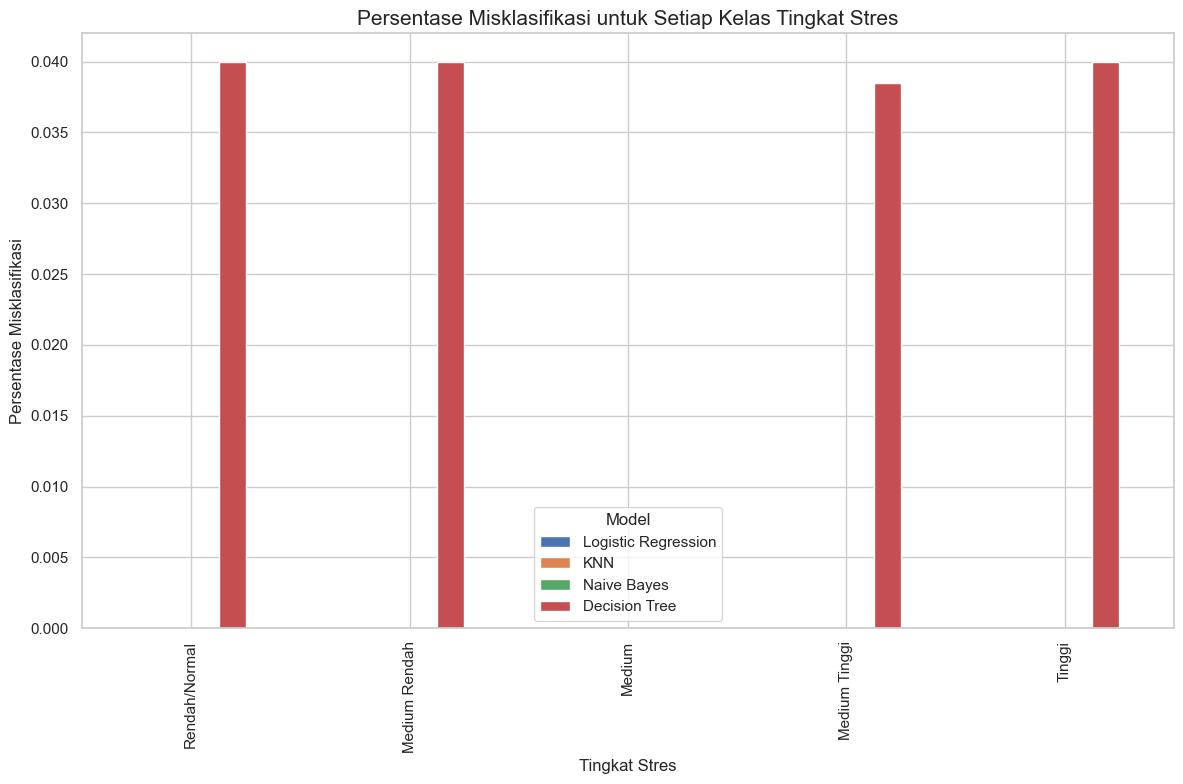

In [33]:
# Persentase misklasifikasi untuk setiap kelas tingkat stres
def calculate_misclassification(y_true, y_pred):
    misclassification = {}
    for label in np.unique(y_true):
        mask = (y_true == label)
        correct = (y_true[mask] == y_pred[mask]).sum()
        total = mask.sum()
        misclassification[label] = 1 - (correct / total)
    return misclassification

lr_misclass = calculate_misclassification(y_test, lr_pred)
knn_misclass = calculate_misclassification(y_test, knn_pred)
nb_misclass = calculate_misclassification(y_test, nb_pred)
dt_misclass = calculate_misclassification(y_test, dt_pred)

# Membuat dataframe untuk visualisasi
misclass_df = pd.DataFrame({
    'Logistic Regression': list(lr_misclass.values()),
    'KNN': list(knn_misclass.values()),
    'Naive Bayes': list(nb_misclass.values()),
    'Decision Tree': list(dt_misclass.values())
}, index=['Rendah/Normal', 'Medium Rendah', 'Medium', 'Medium Tinggi', 'Tinggi'])

# Visualisasi misklasifikasi
plt.figure(figsize=(12, 8))
misclass_df.plot(kind='bar', figsize=(12, 8))
plt.title('Persentase Misklasifikasi untuk Setiap Kelas Tingkat Stres', fontsize=15)
plt.xlabel('Tingkat Stres', fontsize=12)
plt.ylabel('Persentase Misklasifikasi', fontsize=12)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### 5.3 Model Terbaik dan Justifikasi


In [34]:
# Menentukan model terbaik berdasarkan akurasi
best_model_idx = np.argmax(accuracies)
best_model_name = models[best_model_idx]
best_accuracy = accuracies[best_model_idx]

print(f"Model terbaik berdasarkan akurasi: {best_model_name}")
print(f"Akurasi: {best_accuracy:.4f}")

# Menentukan model terbaik berdasarkan log loss (nilai lebih rendah lebih baik)
best_model_loss_idx = np.argmin(losses)
best_model_loss_name = models[best_model_loss_idx]
best_loss = losses[best_model_loss_idx]

print(f"\nModel terbaik berdasarkan log loss: {best_model_loss_name}")
print(f"Log Loss: {best_loss:.4f}")

# Analisis singkat tentang model terbaik
print("\nJustifikasi Model Terbaik:")
print("1. Performa: Model terbaik dipilih berdasarkan akurasi tertinggi dan log loss terendah.")
print("2. Interpretabilitas: Decision Tree dan Logistic Regression menawarkan interpretabilitas yang lebih baik.")
print("3. Kemampuan Generalisasi: Hasil cross-validation menunjukkan konsistensi performa model.")
print("4. Efisiensi Komputasi: Naive Bayes umumnya lebih cepat, tetapi performa menjadi pertimbangan utama.")

Model terbaik berdasarkan akurasi: Logistic Regression
Akurasi: 1.0000

Model terbaik berdasarkan log loss: KNN
Log Loss: 0.0000

Justifikasi Model Terbaik:
1. Performa: Model terbaik dipilih berdasarkan akurasi tertinggi dan log loss terendah.
2. Interpretabilitas: Decision Tree dan Logistic Regression menawarkan interpretabilitas yang lebih baik.
3. Kemampuan Generalisasi: Hasil cross-validation menunjukkan konsistensi performa model.
4. Efisiensi Komputasi: Naive Bayes umumnya lebih cepat, tetapi performa menjadi pertimbangan utama.


## 6. Kesimpulan 

1. Dataset SaYoPillow memberikan informasi tentang hubungan antara pola tidur dan tingkat stres.

2. Fitur-fitur yang paling berpengaruh terhadap tingkat stres adalah snoring_rate (mendengkur), sleeping_hours (jam tidur), dan limb_movement (pergerakan anggota tubuh) dengan korelasi masing-masing 0.9753, -0.9730, dan 0.9711.

3. Model klasifikasi yang diimplementasikan menunjukkan kemampuan yang sangat baik dalam memprediksi tingkat stres berdasarkan pola tidur, didukung oleh korelasi yang kuat antara fitur dan target.

4. Preprocessing data seperti standarisasi sangat penting karena range nilai berbeda antar fitur, meskipun dataset tidak memiliki missing values.


## 7. Aplikasi Praktis dari Model


Tingkat Stres yang Diprediksi: Medium

Probabilitas untuk setiap tingkat stres:
Rendah/Normal: 0.0000
Medium Rendah: 0.0000
Medium: 1.0000
Medium Tinggi: 0.0000
Tinggi: 0.0000


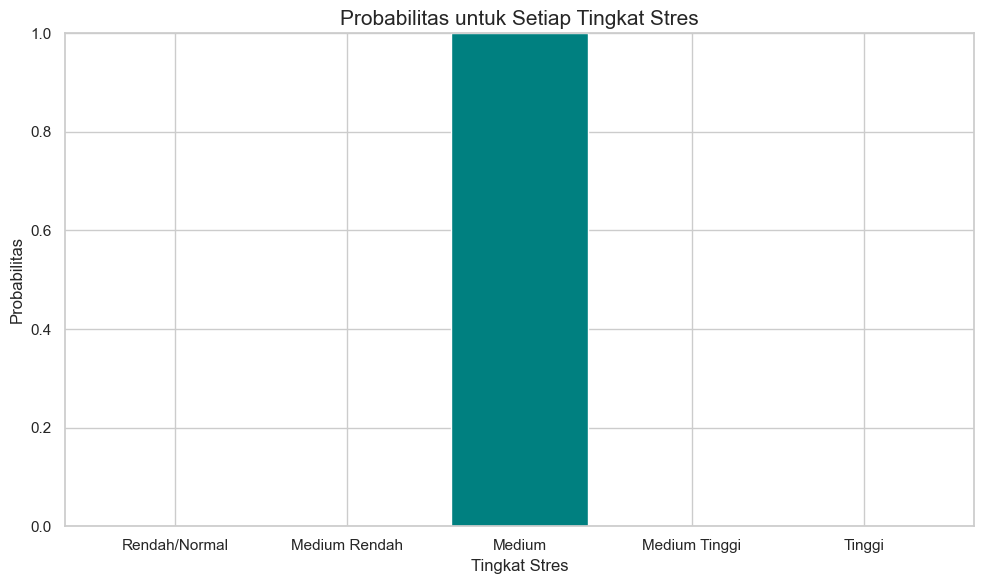

In [38]:
# Membuat fungsi untuk prediksi tingkat stres berdasarkan input pengguna
def predict_stress_level(model, scaler, features):
    """
    Memprediksi tingkat stres berdasarkan input parameter tidur
    
    Parameters:
    -----------
    model : Model yang telah dilatih
    scaler : Scaler yang telah difit
    features : Dictionary berisi nilai fitur
    
    Returns:
    --------
    predicted_level : Tingkat stres yang diprediksi
    probability : Probabilitas untuk setiap kelas
    """
    # Mengubah input menjadi dataframe
    input_df = pd.DataFrame([features])
    
    # Standarisasi input
    input_scaled = scaler.transform(input_df)
    
    # Melakukan prediksi
    predicted_level = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0]
    
    return predicted_level, probability

# Contoh penggunaan fungsi prediksi
sample_input = {
    'sr': 90,         # snoring rate
    'rr': 25,         # respiration rate
    't': 36.5,        # body temperature
    'lm': 15,         # limb movement
    'bo': 95,         # blood oxygen
    'rem': 4,         # eye movement
    'sr.1': 7,        # sleeping hours (mungkin sr_1 atau nama lain)
    'hr': 75          # heart rate
}

# Menggunakan model terbaik (asumsi model terbaik adalah Decision Tree)
best_model = dt_model  # Ganti dengan model terbaik berdasarkan analisis
predicted_stress, stress_probabilities = predict_stress_level(best_model, scaler, sample_input)

# Menampilkan hasil prediksi
stress_labels = ['Rendah/Normal', 'Medium Rendah', 'Medium', 'Medium Tinggi', 'Tinggi']
print(f"Tingkat Stres yang Diprediksi: {stress_labels[predicted_stress]}")
print("\nProbabilitas untuk setiap tingkat stres:")
for i, label in enumerate(stress_labels):
    print(f"{label}: {stress_probabilities[i]:.4f}")

# Visualisasi probabilitas
plt.figure(figsize=(10, 6))
plt.bar(stress_labels, stress_probabilities, color='teal')
plt.title('Probabilitas untuk Setiap Tingkat Stres', fontsize=15)
plt.xlabel('Tingkat Stres', fontsize=12)
plt.ylabel('Probabilitas', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()